In [1]:
import findspark
findspark.init()
findspark.find()

'/Applications/anaconda3/lib/python3.8/site-packages/pyspark'

In [2]:
#Import PySpark
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('SparkExample').getOrCreate()

In [8]:
#Load Iris Dataset
import pandas as pd
from sklearn.datasets import load_iris

df_iris = load_iris(as_frame=True)
#df_iris

In [11]:
pd_df_iris = pd.DataFrame(df_iris.data, columns=df_iris.feature_names)
pd_df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [13]:
pd_df_iris['target'] = pd.Series(df_iris.target)
pd_df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [35]:
pd_df_iris[['petal length (cm)','petal width (cm)']].head()

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


In [15]:
spark_df_iris = spark.createDataFrame(pd_df_iris)
spark_df_iris = spark_df_iris.drop("target")

In [16]:
#create a vector assembler and transform raw features into a single set of features.
from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(inputCols=[
 'sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)'], outputCol = 'iris_features')

assembled_data = assemble.transform(spark_df_iris)


In [17]:
assembled_data

DataFrame[sepal length (cm): double, sepal width (cm): double, petal length (cm): double, petal width (cm): double, iris_features: vector]

In [20]:
#Calculate silhouette_scores for K in range(2,11)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores = []
evaluator = ClusteringEvaluator(featuresCol='iris_features',
                               metricName='silhouette',distanceMeasure='squaredEuclidean')

for K in range(2,11):
    
    KMeans_ = KMeans(featuresCol='iris_features',k=K)
    
    KMeans_fit = KMeans_.fit(assembled_data)
    
    KMeans_transform = KMeans_fit.transform(assembled_data)
    
    evaluation_score = evaluator.evaluate(KMeans_transform)
    
    silhouette_scores.append(evaluation_score)

print(silhouette_scores)

[0.850351222925148, 0.7344130579787832, 0.6820331437422406, 0.6711136432291338, 0.5539050829155837, 0.5022983141838967, 0.5216942369622205, 0.5039094255530646, 0.5179306516648461]


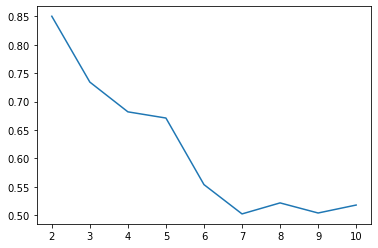

In [27]:
#plot the silhouette scores against the number of clusters.
import matplotlib.pyplot as plt

plt.plot(range(2,11),silhouette_scores)


In [29]:
#Build the K-Means Clustering model

#let’s build the model with 3 clusters.

KMeans_ = KMeans(featuresCol='iris_features',k=3)
KMeans_Model = KMeans_.fit(assembled_data)
KMeans_Assignments = KMeans_Model.transform(assembled_data)
KMeans_Assignments 

DataFrame[sepal length (cm): double, sepal width (cm): double, petal length (cm): double, petal width (cm): double, iris_features: vector, prediction: int]

In [49]:
import numpy as np

cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

#cluster_assignment

In [56]:
clusters_ = cluster_assignment.reshape(1,-1)
clusters_[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [57]:
clusters_[0].shape

(150,)

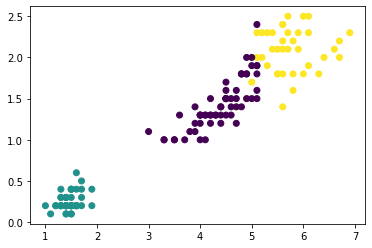

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

#petal length (cm)
#load_iris().data[:,2]
petal_length = load_iris().data[:,2]

#petal width (cm)
#load_iris().data[:,3]
petal_width = load_iris().data[:,3]

plt.scatter(petal_length,petal_width,c=clusters_)


In [59]:
from sklearn.metrics import silhouette_score

#load_iris().data
score = silhouette_score(X=load_iris().data,labels=clusters_[0])
score

0.5511916046195915